# King County Real Estate Data Investigation
### Identifying successful house flippers

Analysis Date: 1/18/2019

Data can be found here: https://info.kingcounty.gov/assessor/DataDownload/default.aspx

File used: `Real Property Sales (.ZIP)`

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read in the Sale Data
sale_master = pd.read_csv('EXTR_RPSale.csv', low_memory = False)


In [52]:
# Create a copy of the master data
sale_data = sale_master

# Filter to residential properties only:
sale_data = sale_data[(sale_data.loc[:,'PropertyClass'] == 7) |
                      (sale_data.loc[:,'PropertyClass'] == 8) |
                      (sale_data.loc[:,'PropertyClass'] == 9)]

# Remove sales less than $5000
sale_data = sale_data[(sale_data.loc[:,'SalePrice'] >= 5000)]

sale_data.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
0,2687551,138860,0110,08/21/2014,245000,20140828001436,,,,,...,3,6,3,N,N,N,N,1,8,
4,1056831,951120,0900,04/20/1989,85000,198904260448,117,053,951120,P,...,3,0,2,N,N,N,N,1,9,49
6,1813750,012307,9020,04/25/2001,5755000,20010426001305,,,,,...,1,9,3,N,N,N,N,1,7,11 16 45
7,1813750,012307,9005,04/25/2001,5755000,20010426001305,,,,,...,1,9,3,N,N,N,N,1,7,11 16 45
8,1813750,122209,9002,04/25/2001,5755000,20010426001305,,,,,...,1,9,3,N,N,N,N,1,7,11 16 45


### Dimensions

`Major` and `Minor` are components of the Parcel ID Number ( `PIN` ) which can be used as a primary key for each household.

The `ExciseTaxNbr` refers to the excise tax identifier for each sale of real estate. For our purposes, we will consider rows with duplicated `ExciseTaxNbr` to be invalid.

### Metrics

To identify a flip, we will be looking at the duration of ownership versus the increase in housing price.

To identify price, we will use `SalePrice`

To identify the sale date, we will use `DocumentDate`

In [53]:
# Reduce data to include only columns of interest.
sale_data = sale_data.iloc[:,:5]
sale_data.head(10)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice
0,2687551,138860,0110,08/21/2014,245000
4,1056831,951120,0900,04/20/1989,85000
6,1813750,012307,9020,04/25/2001,5755000
7,1813750,012307,9005,04/25/2001,5755000
8,1813750,122209,9002,04/25/2001,5755000
9,1813750,122209,9001,04/25/2001,5755000
10,1813750,022209,9001,04/25/2001,5755000
11,1813750,022209,9003,04/25/2001,5755000
12,1813750,342309,9012,04/25/2001,5755000
13,1813750,342309,9011,04/25/2001,5755000


### Determine which rows are duplicated by Excise Tax Number

The parameter `keep` in the `duplicated` method refers to whether to consider the first occurence of a repeated value a non-duplicate record.

Since we are not interested in any properties that were sold in a bulk real estate transaction, we set `keep` =  __False__ 

In [54]:
# Determine which rows are duplicated by Excise Tax Number
sale_data['is_duplicate'] = sale_data.duplicated('ExciseTaxNbr',keep = False)
sale_data.head(10)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,is_duplicate
0,2687551,138860,0110,08/21/2014,245000,False
4,1056831,951120,0900,04/20/1989,85000,False
6,1813750,012307,9020,04/25/2001,5755000,True
7,1813750,012307,9005,04/25/2001,5755000,True
8,1813750,122209,9002,04/25/2001,5755000,True
9,1813750,122209,9001,04/25/2001,5755000,True
10,1813750,022209,9001,04/25/2001,5755000,True
11,1813750,022209,9003,04/25/2001,5755000,True
12,1813750,342309,9012,04/25/2001,5755000,True
13,1813750,342309,9011,04/25/2001,5755000,True


In [55]:
# Filter to records that are not duplicates
sale_data = sale_data[sale_data['is_duplicate']==False]
sale_data.head(10)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,is_duplicate
0,2687551,138860,0110,08/21/2014,245000,False
4,1056831,951120,0900,04/20/1989,85000,False
25,2548641,330395,1610,06/07/2012,335000,False
26,1598443,675260,0940,03/06/1998,209950,False
29,2743355,638580,0110,07/14/2015,190000,False
47,2627121,635260,0480,08/22/2013,890000,False
48,1905770,234570,0180,08/19/2002,313500,False
50,2124050,162304,9355,05/13/2005,237000,False
51,1621884,721541,0340,06/25/1998,279500,False
53,1579184,397170,0951,11/13/1997,137500,False


### Create the `PIN` field
Concatenate `Major` and `Minor`

In [56]:
# Cast the numbers in major and minor to String
sale_data['Major'] = sale_data['Major'].apply(str)
sale_data['Minor'] = sale_data['Minor'].apply(str)

sale_data['PIN'] = sale_data['Major'] + sale_data['Minor']
sale_data.head(10)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,is_duplicate,PIN
0,2687551,138860,0110,08/21/2014,245000,False,1388600110
4,1056831,951120,0900,04/20/1989,85000,False,9511200900
25,2548641,330395,1610,06/07/2012,335000,False,3303951610
26,1598443,675260,0940,03/06/1998,209950,False,6752600940
29,2743355,638580,0110,07/14/2015,190000,False,6385800110
47,2627121,635260,0480,08/22/2013,890000,False,6352600480
48,1905770,234570,0180,08/19/2002,313500,False,2345700180
50,2124050,162304,9355,05/13/2005,237000,False,1623049355
51,1621884,721541,0340,06/25/1998,279500,False,7215410340
53,1579184,397170,0951,11/13/1997,137500,False,3971700951


### Transactional Data

To determine duration of ownership and change in price, we need to use properties with more than one sale record.

Duration of Ownership = ( `DocumentDate` _i+1_ - `DocumentDate` _i_ )

Change in Price = (`SalePrice` _i+1_ - `SalePrice` _i_ )


In [57]:
# Determine which Properties have been resold

# Any `PIN` duplicates means that house has been resold 
# Again, we want to use keep = False because we want all records of that property to be considered duplicates
sale_data['is_resold'] = sale_data.duplicated('PIN', keep = False)
sale_data.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,is_duplicate,PIN,is_resold
0,2687551,138860,0110,08/21/2014,245000,False,1388600110,True
4,1056831,951120,0900,04/20/1989,85000,False,9511200900,False
25,2548641,330395,1610,06/07/2012,335000,False,3303951610,True
26,1598443,675260,0940,03/06/1998,209950,False,6752600940,True
29,2743355,638580,0110,07/14/2015,190000,False,6385800110,True


In [72]:
# Filter out properties that have not been resold
resold_data = sale_data[sale_data['is_resold'] == True]
resold_data.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,is_duplicate,PIN,is_resold
0,2687551,138860,0110,08/21/2014,245000,False,1388600110,True
25,2548641,330395,1610,06/07/2012,335000,False,3303951610,True
26,1598443,675260,0940,03/06/1998,209950,False,6752600940,True
29,2743355,638580,0110,07/14/2015,190000,False,6385800110,True
47,2627121,635260,0480,08/22/2013,890000,False,6352600480,True


In [78]:
# Convert Date field to pd.Timestamp so we can caluclate the duration of ownership

# WARNING: Takes a long time
resold_data.loc[:,'DocumentDate'] = resold_data.DocumentDate.apply(pd.Timestamp)
print(type(resold_data.DocumentDate[0]))
resold_data.head(10)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,is_duplicate,PIN,is_resold
0,2687551,138860,0110,2014-08-21,245000,False,1388600110,True
25,2548641,330395,1610,2012-06-07,335000,False,3303951610,True
26,1598443,675260,0940,1998-03-06,209950,False,6752600940,True
29,2743355,638580,0110,2015-07-14,190000,False,6385800110,True
47,2627121,635260,0480,2013-08-22,890000,False,6352600480,True
48,1905770,234570,0180,2002-08-19,313500,False,2345700180,True
50,2124050,162304,9355,2005-05-13,237000,False,1623049355,True
51,1621884,721541,0340,1998-06-25,279500,False,7215410340,True
53,1579184,397170,0951,1997-11-13,137500,False,3971700951,True
56,1341660,711650,0120,1993-11-02,88000,False,7116500120,True


### Reorder & Reorganize Dataset

In [79]:
# reorder based on PIN and Date
resold_data = resold_data.sort_values(['PIN','DocumentDate'])

# reset row indexes
resold_data = resold_data.reset_index()

# filter to columns
resold_data = resold_data.loc[:,['PIN','DocumentDate','SalePrice']]

# rename columns
resold_data.columns = ['PIN','Date','SalePrice']


resold_data.head(10)

,PIN,Date,SalePrice
0,0001000003,1982-03-03,60000
1,0001000003,2004-11-12,420000
2,0001000003,2005-04-22,450000
3,0001000003,2006-07-07,495000
4,0001000003,2012-03-20,275000
5,0001000009,2004-07-08,197500
6,0001000009,2005-10-03,212500
7,0001000009,2006-05-23,285000
8,0001000009,2012-10-04,194000
9,0001000025,1995-03-07,5345


In [47]:
#
#


#### WARNING: TAKES A LONG TIME

#grouped_data = sale_data.groupby(['PIN','Date'])
#grouped_data = pd.DataFrame(grouped_data['SalePrice'].aggregate(np.mean)).reset_index()
#grouped_data['Date'] = grouped_data['Date'].apply(pd.Timestamp)
#sale_data.head(50)
#list(np.array(grouped_data.loc[0:5,'Major']))


### Condense transactional data to include _before_ and _after_ data in one row

In [80]:
def get_flips(resold_data):
    current_pin = None
    previous_pin = None
    for row in resold_data.to_dict(orient='records'):
        current_pin = row['PIN']
        current_date = row['Date']
        current_price = row['SalePrice']
        if current_pin == previous_pin:
            time_delta = current_date - previous_date
            price_delta = current_price - previous_price
            yield {
                'pin': current_pin,
                'date_bought': previous_date,
                'date_sold': current_date,
                'price_bought': previous_price,
                'price_sold': current_price,
                'price_delta': price_delta,
                'time_delta': time_delta
            }
        previous_price = current_price
        previous_pin = current_pin
        previous_date = current_date
    

In [82]:
# Resulting data frame of property ownerships
# Warning - Takes a long time
flips_df = pd.DataFrame(get_flips(resold_data))
flips_df.head(10)

,date_bought,date_sold,pin,price_bought,price_delta,price_sold,time_delta
0,1982-03-03,2004-11-12,0001000003,60000,360000,420000,8290 days
1,2004-11-12,2005-04-22,0001000003,420000,30000,450000,161 days
2,2005-04-22,2006-07-07,0001000003,450000,45000,495000,441 days
3,2006-07-07,2012-03-20,0001000003,495000,-220000,275000,2083 days
4,2004-07-08,2005-10-03,0001000009,197500,15000,212500,452 days
5,2005-10-03,2006-05-23,0001000009,212500,72500,285000,232 days
6,2006-05-23,2012-10-04,0001000009,285000,-91000,194000,2326 days
7,1995-03-07,1998-03-05,0001000025,5345,294655,300000,1094 days
8,1995-01-05,1998-03-06,0001000026,5345,294655,300000,1156 days
9,1997-03-18,2002-02-07,0001000035,225000,-30000,195000,1787 days


In [83]:
# Create new column with percentage difference between price sold and price bought
flips_df['pcnt_price_diff'] = ((flips_df['price_sold'] / flips_df['price_bought'])-1) * 100
flips_df.head()

,date_bought,date_sold,pin,price_bought,price_delta,price_sold,time_delta,pcnt_price_diff
0,1982-03-03,2004-11-12,0001000003,60000,360000,420000,8290 days,600.000000
1,2004-11-12,2005-04-22,0001000003,420000,30000,450000,161 days,7.142857
2,2005-04-22,2006-07-07,0001000003,450000,45000,495000,441 days,10.000000
3,2006-07-07,2012-03-20,0001000003,495000,-220000,275000,2083 days,-44.444444
4,2004-07-08,2005-10-03,0001000009,197500,15000,212500,452 days,7.594937


In [84]:
# Create 2 new columns: Days that the property was owned and Years that the property was owned
flips_df['days_owned'] = flips_df['time_delta'].apply(lambda x: x.days)
flips_df['years_owned'] = flips_df['days_owned'] /365
flips_df.head(10)

,date_bought,date_sold,pin,price_bought,price_delta,price_sold,time_delta,pcnt_price_diff,days_owned,years_owned
0,1982-03-03,2004-11-12,0001000003,60000,360000,420000,8290 days,600.000000,8290,22.712329
1,2004-11-12,2005-04-22,0001000003,420000,30000,450000,161 days,7.142857,161,0.441096
2,2005-04-22,2006-07-07,0001000003,450000,45000,495000,441 days,10.000000,441,1.208219
3,2006-07-07,2012-03-20,0001000003,495000,-220000,275000,2083 days,-44.444444,2083,5.706849
4,2004-07-08,2005-10-03,0001000009,197500,15000,212500,452 days,7.594937,452,1.238356
5,2005-10-03,2006-05-23,0001000009,212500,72500,285000,232 days,34.117647,232,0.635616
6,2006-05-23,2012-10-04,0001000009,285000,-91000,194000,2326 days,-31.929825,2326,6.372603
7,1995-03-07,1998-03-05,0001000025,5345,294655,300000,1094 days,5512.722170,1094,2.997260
8,1995-01-05,1998-03-06,0001000026,5345,294655,300000,1156 days,5512.722170,1156,3.167123
9,1997-03-18,2002-02-07,0001000035,225000,-30000,195000,1787 days,-13.333333,1787,4.895890


In [198]:
#flips_df['ppd_over_time'] = flips_df['percent_price_difference'] / (flips_df['time_delta_days'] /365)

flips_df['year_delta'] = flips_df['time_delta_days'] /365

In [199]:
flips_df.head()

,date_bought,date_sold,pin,price_bought,price_delta,price_sold,time_delta,percent_price_difference,time_delta_days,ppd_over_time,year_delta
0,2005-05-09,2017-07-05,0001400033,100000.0,220000.0,320000.0,4440 days,2.200000,4440,0.180856,12.164384
1,1997-09-18,2015-10-21,0009000290,284000.0,443500.0,727500.0,6607 days,1.561620,6607,0.086271,18.101370
2,1992-12-16,2007-06-19,0011510250,226900.0,373100.0,600000.0,5298 days,1.644337,5298,0.113285,14.515068
3,1992-12-01,1998-07-10,0011510460,229950.0,95050.0,325000.0,2047 days,0.413351,2047,0.073704,5.608219
4,2001-03-19,2004-07-12,0088000690,89000.0,194000.0,283000.0,1211 days,2.179775,1211,0.656993,3.317808


In [94]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

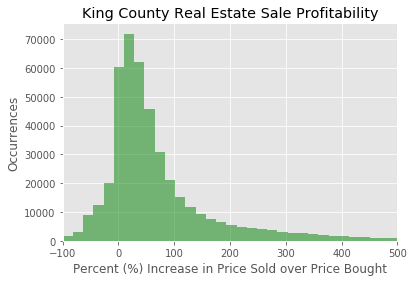

In [133]:
plt.hist(flips_df[flips_df['pcnt_price_diff'] < 1000].pcnt_price_diff, bins = 60, color='green', alpha = 0.5)
plt.xlim(-100,500)
plt.title('King County Real Estate Sale Profitability')
plt.xlabel('Percent (%) Increase in Price Sold over Price Bought')
plt.ylabel('Occurrences')
plt.show()


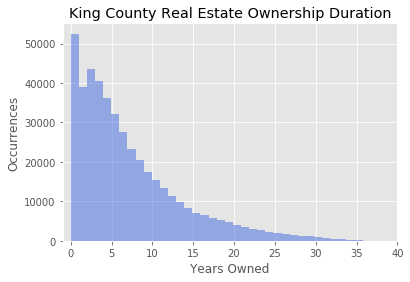

In [134]:
plt.hist(flips_df.years_owned, bins = 75, color = 'royalblue', alpha = 0.5)
plt.xlim(-1,40)
plt.title('King County Real Estate Ownership Duration')
plt.xlabel('Years Owned')
plt.ylabel('Occurrences')
plt.show()

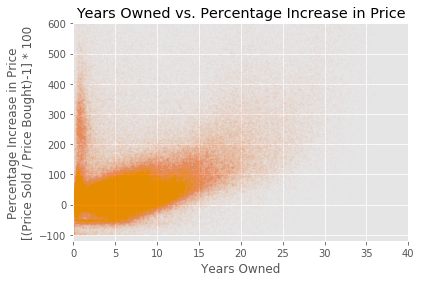

In [132]:
plt.scatter(flips_df.years_owned, flips_df.pcnt_price_diff, alpha = 0.015, s = 1, color = 'darkorange')
plt.ylim(-120,600)
plt.xlim(0,40)
plt.title('Years Owned vs. Percentage Increase in Price')
plt.xlabel('Years Owned')
plt.ylabel('Percentage Increase in Price\n[(Price Sold / Price Bought)-1] * 100')
plt.show()

In [139]:
plt.boxplot(flips_df.pcnt_price_diff,showfliers = False, color = 'blue')
        
        
        

TypeError: boxplot() got an unexpected keyword argument 'color'

In [159]:
flips_df['years_owned_rounded'] = flips_df.years_owned // 1

In [160]:

bpdata = [flips_df[flips_df.years_owned_rounded == 0].pcnt_price_diff,
         flips_df[flips_df.years_owned_rounded == 1].pcnt_price_diff,
         flips_df[flips_df.years_owned_rounded == 2].pcnt_price_diff,
         flips_df[flips_df.years_owned_rounded == 3].pcnt_price_diff]

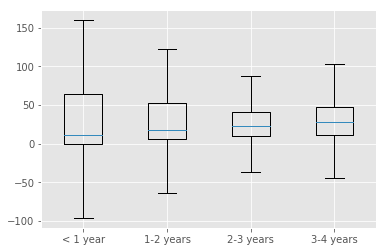

In [161]:
bp = plt.boxplot(bpdata,showfliers = False, labels = ['< 1 year', '1-2 years', '2-3 years','3-4 years'])
plt.show()

In [165]:
short_data = flips_df[(flips_df.years_owned < 1.5) & (flips_df.pcnt_price_diff < 500)]
short_data.head()

,date_bought,date_sold,pin,price_bought,price_delta,price_sold,time_delta,pcnt_price_diff,days_owned,years_owned,years_owned_rounded
1,2004-11-12,2005-04-22,0001000003,420000,30000,450000,161 days,7.142857,161,0.441096,0.0
2,2005-04-22,2006-07-07,0001000003,450000,45000,495000,441 days,10.000000,441,1.208219,1.0
4,2004-07-08,2005-10-03,0001000009,197500,15000,212500,452 days,7.594937,452,1.238356,1.0
5,2005-10-03,2006-05-23,0001000009,212500,72500,285000,232 days,34.117647,232,0.635616,0.0
12,2016-07-18,2017-03-10,0001000044,210001,131799,341800,235 days,62.761130,235,0.643836,0.0


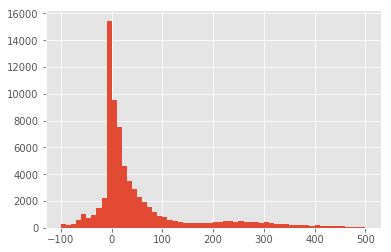

In [168]:

plt.hist(short_data.pcnt_price_diff, bins = 60)
plt.show()

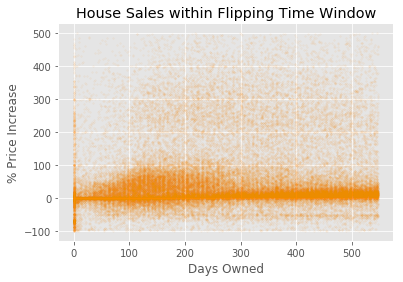

In [179]:
plt.scatter(short_data.days_owned,short_data.pcnt_price_diff, alpha = 0.05, s = 3, color = 'darkorange')
plt.title('House Sales within Flipping Time Window')
plt.xlabel('Days Owned')
plt.ylabel('% Price Increase')
plt.show()

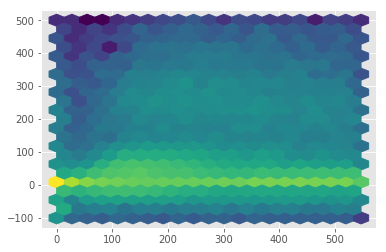

In [230]:
plt.hexbin(x = short_data.days_owned, y = short_data.pcnt_price_diff, gridsize = 20, bins = 'log') #, C=z, gridsize=gridsize, cmap=CM.jet, bins=None)
plt.show()



# Join in other Residential Data

In [181]:
residential = pd.read_csv('EXTR_ResBldg.csv', low_memory = False)

In [184]:
residential['Major'] = residential.Major.apply(str)
residential['Minor'] = residential.Minor.apply(str)
residential['PIN'] = residential['Major'] + residential['Minor']
residential.head()

,Major,Minor,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,PIN
0,22506,9059,1,1,8407 225TH AVE NE 98053,8407,,,225TH,AVE,...,0,0,2006,0,0,0,0,3,0,225069059
1,22510,82,1,1,7846 122ND AVE NE 98033,7846,,,122ND,AVE,...,0,0,1961,0,0,0,0,4,0,2251082
2,22510,127,1,1,12224 NE 75TH ST 98033,12224,,NE,75TH,ST,...,1,0,1963,0,0,0,0,3,0,22510127
3,22603,9011,1,1,2112 NW 199TH ST 98177,2112,,NW,199TH,ST,...,0,0,1918,0,0,0,0,3,0,226039011
4,22603,9146,1,1,20002 20TH AVE NW 98177,20002,,,20TH,AVE,...,1,0,1949,0,0,0,0,3,0,226039146


In [199]:
residential.columns

Index(['Major', 'Minor', 'BldgNbr', 'NbrLivingUnits', 'Address',
       'BuildingNumber', 'Fraction', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'BldgGradeVar', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
       'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem',
       'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'PcntComplete', 'Obsolescence', 'PcntNetCondition',
       'Condition', 'AddnlCost', 'PIN'],
      dtype='object')

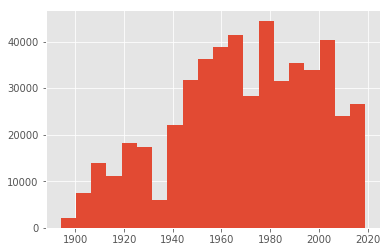

In [206]:
plt.hist(residential.YrBuilt, bins = 20)
plt.show()

In [207]:
set(residential.ZipCode)

{' ',
 '0',
 '28028',
 '3',
 '8126',
 '89118',
 '90055',
 '90108',
 '90855',
 '95055',
 '95059',
 '95125',
 '98',
 '9800',
 '98000',
 '98001',
 '98002',
 '98003',
 '98003-4264',
 '98004',
 '98005',
 '98006',
 '98006-3954',
 '98006-4057',
 '98007',
 '98008',
 '98008-4321',
 '98008-4429',
 '98009',
 '98010',
 '98011',
 '98011-3777',
 '98013',
 '98014',
 '98017',
 '98018',
 '98019',
 '98021',
 '98022',
 '98023',
 '98023-2712',
 '98023-7330',
 '98023-7841',
 '98024',
 '98025',
 '98026',
 '98027',
 '98028',
 '98028-1654',
 '98028-1814',
 '98028-2118',
 '98028-3200',
 '98028-4228',
 '98028-4365',
 '98028-4377',
 '98028-4505',
 '98028-4625',
 '98028-4712',
 '98028-4768',
 '98028-6100',
 '98028-7915',
 '98028-8533',
 '98028-8908',
 '98029',
 '98029-3602',
 '98030',
 '98031',
 '98031-3173',
 '98032',
 '98033',
 '98033-4917',
 '98033-5040',
 '98033-8239',
 '98034',
 '98034-2540',
 '98035',
 '98038',
 '98038-3112',
 '98039',
 '9804',
 '98040',
 '98042',
 '98042-3001',
 '98042-4811',
 '98042-8114'

In [208]:
set(residential.BldgGrade)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20}

In [215]:
residential['is_duplicate'] = residential.duplicated('PIN', keep = False)
#residential.head()
print(sum(residential.is_duplicate == True), len(residential.is_duplicate), (sum(residential.is_duplicate == True) / len(residential.is_duplicate)))

10451 511135 0.02044665303686893


In [216]:
residential = residential[residential.is_duplicate == False]

In [224]:
flips_info = short_data.merge(residential, left_on = 'pin', right_on = 'PIN', how = 'inner')
flips_info.head()

,date_bought,date_sold,pin,price_bought,price_delta,price_sold,time_delta,pcnt_price_diff,days_owned,years_owned,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,PIN,is_duplicate
0,2016-07-05,2017-07-17,1020069048,487600,27300,514900,377 days,5.598852,377,1.032877,...,0,1900,2007,0,0,0,3,6000,1020069048,False
1,2006-02-09,2006-08-02,1020069058,275000,169000,444000,174 days,61.454545,174,0.476712,...,0,2007,0,0,0,0,3,9000,1020069058,False
2,2005-03-23,2006-05-30,1020069060,765000,80000,845000,433 days,10.457516,433,1.186301,...,0,1998,0,0,0,0,3,6500,1020069060,False
3,2002-06-19,2003-11-07,1021039018,318950,36050,355000,506 days,11.302712,506,1.386301,...,0,1989,0,0,0,0,3,0,1021039018,False
4,2016-04-29,2016-06-09,1021039019,450000,0,450000,41 days,0.000000,41,0.112329,...,0,1989,0,0,0,0,3,0,1021039019,False


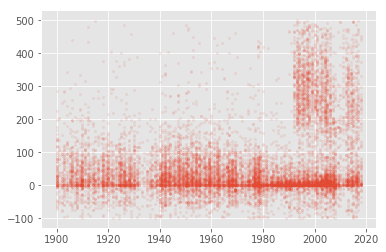

In [228]:
plt.scatter(flips_info.YrBuilt,flips_info.pcnt_price_diff, alpha = 0.1, s = 5)
plt.show()

In [234]:
bpdata2 = [flips_info[flips_info.Bedrooms == 1].pcnt_price_diff,
           flips_info[flips_info.Bedrooms == 2].pcnt_price_diff,
           flips_info[flips_info.Bedrooms == 3].pcnt_price_diff,
           flips_info[flips_info.Bedrooms == 4].pcnt_price_diff,
           flips_info[flips_info.Bedrooms == 5].pcnt_price_diff,
           flips_info[flips_info.Bedrooms == 6].pcnt_price_diff,
           flips_info[flips_info.Bedrooms > 6].pcnt_price_diff]

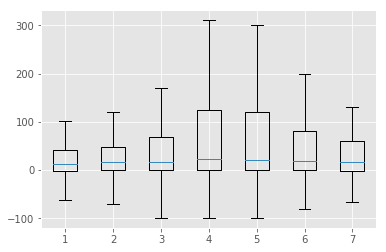

In [236]:
plt.boxplot(bpdata2,showfliers = False)
plt.
plt.show()

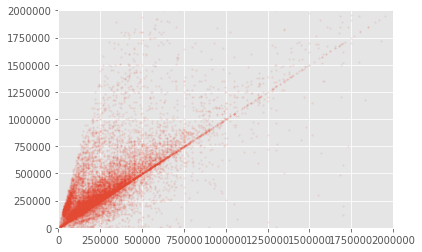

In [240]:
plt.scatter(flips_info.price_bought,flips_info.price_sold,alpha = 0.1,s = 2)
plt.xlim(0,2000000)
plt.ylim(0,2000000)
plt.show()

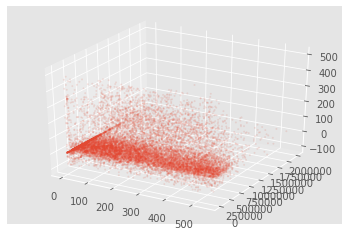

In [250]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
pltdata = flips_info[flips_info.price_bought <= 2000000]
ax.scatter3D(pltdata.days_owned, pltdata.price_bought, pltdata.pcnt_price_diff, s = 2, alpha = 0.1)
plt.show()

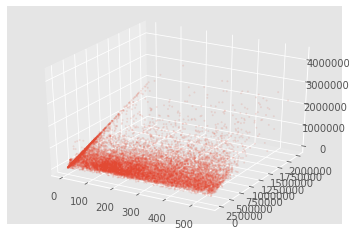

In [252]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
pltdata = flips_info[flips_info.price_bought <= 2000000]
ax.scatter3D(pltdata.days_owned, pltdata.price_bought, pltdata.price_sold, s = 2, alpha = 0.1)
plt.show()

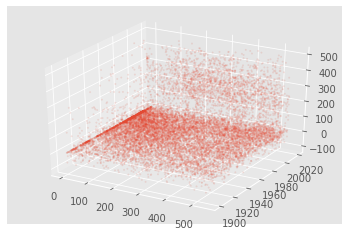

In [253]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
pltdata = flips_info[flips_info.price_bought <= 2000000]
ax.scatter3D(pltdata.days_owned, pltdata.YrBuilt, pltdata.pcnt_price_diff, s = 2, alpha = 0.1)
plt.show()